# Эксперимент №2: расчет характеристик тандемной сети с узлами  MAP/PH/1/N по трём моментам с помощью имитационного моделирования и машинного обучения

В этом эксперименте мы рассчитаем различные характеристики сетей с линейной топологией, в которой случайные величины интервалов поступления и времени обслуживания будут задавать фазовыми распределениями. 

Сначала мы рассчитаем характеристики на заданной сетке статистических параметров с помощью имитационного моделирования сети. Аппроксимацию функцию распределения будем проводить по трем моментов с помощью алгоритма [1]. Затем используем полученные результаты для обучения нейросетевых и других моделей ML, которые сможем использовать для очень быстрой оценки характеристик сетей. Например, такой подход полезен при нахождении решений задач оптимизации топологии, когда характеристики сетей с линейной топологией являются ограничениями в алгоритме ветвей и границ. 


[1] Mary A. Johnson & Michael R. Taaffe (1989) Matching moments to phase distributions: Mixtures of erlang distributions of common order, Communications in Statistics. Stochastic Models, 5:4, 711-743, DOI: 10.1080/15326348908807131


In [1]:
import os
from itertools import product
from collections import namedtuple
import time
from typing import Tuple
import random

from tabulate import tabulate
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches
import numpy as np
import pandas as pd

# Подключаем локальные пакеты
from pyqumo.random import Distribution, Exponential, HyperExponential, Erlang
from pyqumo.cqumo.sim import simulate_tandem


from pyqumo.fitting.johnson89 import fit_mern2
from pyqumo.stats import get_cv, get_skewness, get_noncentral_m2, get_noncentral_m3
from pyqumo.random import HyperErlang

# Поключаем пакеты для ML
import math
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.python.keras import engine
from tensorflow.keras import layers
import seaborn as sns
from scipy import stats

In [2]:
# Настраиваем matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})
# matplotlib.rcParams.update({'font.weight': 'bold'})

In [3]:
def get_std(m1, m2):
    return (m2 - m1**2)**0.5

## ПОСТРОЕНИЕ ПРОГНОЗНОЙ МОДЕЛИ ВРЕМЕНИ МЕЖКОНЦЕВОЙ ЗАДЕРЖКИ МНОГОФАЗНОЙ СЕТИ МАСОВОГО ОБСЛУЖИВАНИЯ С ЛИНЕЙНОЙ ТОПОЛОГИЕЙ

Для оценки времени задержек построим _регрессионную модель_.

## ТАБЛИЦА ТРЕНИРОЧНЫХ ДАННЫХ
Мы получили данные симуляции для различных входных параметров. В общей сложности объем выборки составил 101424 строк. Данную выборку будем использовать для обучения будущих моделей.

In [2]:
pd.options.mode.chained_assignment = None
data = pd.read_csv('data/Tandem_network_with_ph_distribution.csv', index_col='Id')
COLUMNS = [
    'ArrM1',
    'ArrStd',
    'ArrSkewness',
    'SrvM1',
    'SrvStd',
    'SrvSkewness',
    'NetSize', 
    'Capacity',
    ]

In [26]:
plt.ylim([0, 25000])
plt.title('Utilization server ' r'$\rho$' '\n of generated data', fontsize=22)
plt.plot(data['Rho'], 'or')
plt.xlabel(r'Samples', fontsize=20);
plt.ylabel(r'$m_s$ \ $m_a$', fontsize=20);
plt.xticks(color='w')
plt.grid()
plt.savefig('data/images/samples_rho.jpeg', bbox_inches = 'tight')

In [25]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1,2,1)
plt.ylim([0, 25000])
plt.title('Utilization server ' r'$\rho$' '\n of generated data',fontweight="bold")
plt.plot(data['Rho'], 'or')
plt.xlabel(r'Samples', fontweight="bold");
plt.ylabel(r'$m_s$ \ $m_a$');
plt.xticks(color='w')
plt.grid()

ax = fig.add_subplot(1,2,2)
plt.ylim([0, 25])
plt.title('Utilization server ' r'$\rho$' '\n of generated data',fontweight="bold")
plt.plot(simulation_data['Rho'], 'or')
plt.xlabel(r'Samples', fontweight="bold");
plt.ylabel(r'$m_s$ \ $m_a$');
plt.xticks(color='w')
plt.grid()

plt.savefig('data/images/samples_rho.pdf', bbox_inches = 'tight')

Как видно из графиков мы имеем значения $\rho$ сильно превышающие диапазон $(0, 1)$. Нецелесообразно использовать такие данные для дальнейшего обучения моделей. Перед тем как начать отсекать строки, вспомни, что узлы нашей многофазной очереди имеют конечный буфер и пакеты при загруженном узле могут теряться. Значит загрузка на первом узле может быть $\rho >> 1$. Поэтому ограничемся  диапазоном $\rho \in (0, 10]$

In [8]:
simulation_data = data[data['Rho'] <= 10]

Приступим к тренировке моделей

In [10]:
train_data, test_data, y_train, y_test = train_test_split(
    simulation_data, simulation_data.loc[:, ['DelayAvg', 'DeliveryProb']], 
    test_size=0.33, 
    random_state=42)
x_train = train_data.loc[:, COLUMNS]
x_test = test_data.loc[:, COLUMNS]

### МЕТРИКИ
Для оценки полученных моделей нам будут необходимы метрики, а именно:

- Стандартное отклонение

In [11]:
def std(x: np.ndarray, y: np.ndarray) -> float:
    """
    Standard deviation between simulation model 
    values and estimates
    """
    return math.sqrt(np.sum((x-y)**2) / (len(x) - 1))

- Коэффициент корреляции

In [12]:
def corr(x: np.ndarray, y: np.ndarray) -> float:
    """
    Correlation coefficient between simulation model 
    values and estimate 
    """
    r = np.corrcoef(x, y)
    return r[0,1]

- среднеквадратичная ошибка;

```sklearn.metrics.mean_squared_error ```.

- и коэффициент детерминации.

```sklearn.metrics.r2_score```.

### Приступим непосредственно к обучению

-  ## Задача регресии МНК

In [13]:
"""Prepare regression model using Least Squares algorithm"""
def get_ls_regression_model(x_train, x_test, 
                            y_train, y_test) -> (np.ndarray, LinearRegression):
    ls = LinearRegression()
    # ls = Ridge(alpha=.5)
    ls.fit(x_train, y_train)
    ls_y = ls.predict(x_test)

    return ls_y, ls


In [14]:
ls_delay_estimate, ls = get_ls_regression_model(x_train, x_test, 
                                                y_train['DelayAvg'], 
                                                y_test['DelayAvg'])

In [398]:
print(f'R = {corr(y_test["DelayAvg"], ls_delay_estimate):.3f}')
print(f'STD = {std(y_test["DelayAvg"], ls_delay_estimate):.3f}')
print(f'MSE = {mean_squared_error(y_test["DelayAvg"], ls_delay_estimate):.3f}')
print(f'R2 = {r2_score(y_test["DelayAvg"], ls_delay_estimate):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test["DelayAvg"], ls_delay_estimate):.3f}')

R = 0.925
STD = 66.541
MSE = 4427.539
R2 = 0.856
MAPE = 2.712


In [16]:
# DataFrame для отриосвки графиков
draw_data = test_data
draw_data.loc[:,'DelayAvgTest'] = y_test.loc[:,'DelayAvg']
draw_data.loc[:, 'LsDelayEst'] = ls_delay_estimate

In [17]:
# fig, ax = plt.subplots(figsize=(8, 8))
# plt.grid()
# cm = plt.get_cmap('Greens')
# col = [cm(float(i)/(len(y_test))) for i in range((len(y_test)))]
# ax.scatter(draw_data['LsDelayEst'], draw_data['DelayAvgTest'], c=col)
# x = np.linspace(0,800,1000)
# ax.plot(x, x, linestyle='-', linewidth=2.4, color='aquamarine')
# ax.set_title('Least Squares model \n SCATTER DIAGRAM \n  e2e delay estimate', fontweight='bold')

# plt.xlim([0, 800])
# plt.ylim([0, 800])

# plt.xlabel(r'$Test \ Samples$');
# plt.ylabel(r'$Least \ Squares \ Estimates$');
# plt.savefig('data/images/ls_scatter_diagram.pdf')

In [18]:
# net_size = draw_data['NetSize'].unique()
# net_size.sort()
# fig = plt.figure(figsize=(30, 35))
# fig.suptitle('Least Squares \n End2end delay estimates \n',fontweight="bold", fontsize=25)
# plt.subplots_adjust(top=0.92)

# for i in net_size:
#     draw_hist = draw_data.loc[draw_data['NetSize']==i]
#     ax = fig.add_subplot(5, 4, int(i))
#     ax.title.set_text('Network size is ' + str(int(i)))
#     ax = sns.histplot(draw_hist.loc[:,'LsDelayEst'], 
#                       color="mediumseagreen", 
#                       label="Least squares model", kde=True)
#     ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
#                       color="orangered", 
#                       label="Delay test", kde=True)
#     plt.legend()
   

In [27]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(20, 21))
fig.suptitle('Least Squares \n End2end delay estimates \n', 
             fontsize=40,
             fontweight='bold')
# plt.subplots_adjust(top=0.92)
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Network size is ' + str(int(i)), fontweight='bold')
        ax = sns.histplot(draw_hist.loc[:,'LsDelayEst'], 
                          color="mediumseagreen", 
                          label="Least squares model", kde=True)
        ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", 
                          label="Delay test", kde=True)
        
        k += 1
        plt.xlabel('Delays')
plt.legend()
plt.savefig('data/images/ls_histogram.pdf')

-  ## Задача регресии на дереве решений

In [20]:
"""Prepare regression model using Decision Tree algorithm"""
def get_tree_regression_model(x_train, x_test, 
                              y_train, y_test, 
                              max_depth=36, 
                              splitter='best') -> (np.ndarray, DecisionTreeRegressor):
    tree_reg = DecisionTreeRegressor(max_depth=max_depth, splitter=splitter)
    tree_reg.fit(x_train, y_train)
    tree_y = tree_reg.predict(x_test)
    
    # print(f'R = {corr(y_test, tree_y):.3f}')
    # print(f'STD = {std(y_test, tree_y):.3f}')
    # print(f'MSE = {mean_squared_error(y_test, tree_y):.3f}')

    return tree_y, tree_reg

In [21]:
tree_delay_estimate, tree_reg = get_tree_regression_model(x_train, x_test, 
                                                        y_train['DelayAvg'], 
                                                        y_test['DelayAvg'])

In [399]:
print(f'R = {corr(y_test["DelayAvg"], tree_delay_estimate,):.3f}')
print(f'STD = {std(y_test["DelayAvg"], tree_delay_estimate,):.3f}')
print(f'MSE = {mean_squared_error(y_test["DelayAvg"], tree_delay_estimate,):.3f}')
print(f'R2 = {r2_score(y_test["DelayAvg"], tree_delay_estimate,):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test["DelayAvg"], tree_delay_estimate):.3f}')

R = 0.991
STD = 23.527
MSE = 553.488
R2 = 0.982
MAPE = 0.103


In [23]:
draw_data.loc[:, 'TreeDelayEst'] = tree_delay_estimate 

На рисунке представлена **диаграмма рассеивания**

In [24]:
# fig, ax = plt.subplots(figsize=(6, 6))
# # plt.subplots_adjust(top=0.5)
# plt.grid()
# cm = plt.get_cmap('autumn')
# col = [cm(float(i)/(len(y_test))) for i in range((len(y_test)))]
# ax.scatter(draw_data['TreeDelayEst'], draw_data['DelayAvgTest'], c=col)
# x = np.linspace(0,800,1000)
# ax.plot(x, x, linestyle='-', linewidth=2.4, color='red')
# ax.set_title('Tree model \n SCATTER DIAGRAM \n  e2e delay estimate', fontweight='bold')

# plt.xlim([0, 800])
# plt.ylim([0, 800])

# plt.xlabel(r'$Test \ Samples$');
# plt.ylabel(r'$Tree \ estimates$');
# plt.savefig('data/images/tree_scatter_diagram.pdf', bbox_inches = 'tight')

 Для различных длин тандема сетей представлены гистограммы оценок времени межконцевых задержек тестовой выборки.

In [25]:
# net_size = draw_data['NetSize'].unique()
# net_size.sort()
# fig = plt.figure(figsize=(22, 35))
# fig.suptitle('Tree decision \n End2end delay estimates \n', fontsize=16)
# plt.subplots_adjust(top=0.92)

# for i in net_size:
#     draw_hist = draw_data.loc[draw_data['NetSize']==i]
#     ax = fig.add_subplot(5, 4, int(i))
#     ax.title.set_text('Network size is ' + str(int(i)))
#     ax = sns.histplot(draw_hist.loc[:,'TreeDelayEst'], 
#                       color="gold", 
#                       label="Tree model", kde=True)
#     ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
#                       color="orangered", 
#                       label="Delay test", kde=True)
#     plt.legend()

In [28]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(20, 21))
fig.suptitle('Decision Tree \n End2end delay estimates \n', 
             fontsize=40,
             fontweight='bold')
# plt.subplots_adjust(top=0.92)
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Network size is ' + str(int(i)), fontweight='bold')
        ax = sns.histplot(draw_hist.loc[:,'TreeDelayEst'], 
                          color="gold", 
                          label="Tree model", kde=True)
        ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", 
                          label="Delay test", kde=True)
        
        k += 1
        plt.xlabel('Delays')
plt.legend()
plt.savefig('data/images/tree_histogram.pdf')

-  ## Задача регрессии с помощью градиентного бустинга на деревьях решений

In [27]:
"""Prepare regression model using Gradient Boosting algorithm"""
def get_gtb_regression_model(x_train, x_test, 
                             y_train, y_test, 
                             n_estimators=100, 
                             learning_rate=.1,
                             max_depth=10) -> (np.ndarray, GradientBoostingRegressor):
    gtb = GradientBoostingRegressor(n_estimators=n_estimators, 
                                    learning_rate=learning_rate, 
                                    max_depth=max_depth)
    gtb.fit(x_train, y_train)
    gtb_y = gtb.predict(x_test)

    return gtb_y, gtb

In [28]:
gtb_delay_estimate, gtb = get_tree_regression_model(x_train, x_test, 
                                               y_train['DelayAvg'], 
                                               y_test['DelayAvg'])

In [403]:
print(f'R = {corr(y_test["DelayAvg"], gtb_delay_estimate,):.3f}')
print(f'STD = {std(y_test["DelayAvg"], gtb_delay_estimate,):.3f}')
print(f'MSE = {mean_squared_error(y_test["DelayAvg"], gtb_delay_estimate,):.3f}')
print(f'R2 = {r2_score(y_test["DelayAvg"], gtb_delay_estimate,):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test["DelayAvg"], gtb_delay_estimate):.3f}')

R = 0.991
STD = 23.439
MSE = 549.355
R2 = 0.982
MAPE = 0.103


In [30]:
draw_data.loc[:, 'GTBDelayEst'] = gtb_delay_estimate 

In [31]:
# fig, ax = plt.subplots(figsize=(6, 6))
# plt.grid()
# cm = plt.get_cmap('Blues')
# col = [cm(float(i)/(len(y_test))) for i in range((len(y_test)))]
# ax.scatter(draw_data['TreeDelayEst'], draw_data['DelayAvgTest'], c=col)
# x = np.linspace(0,800,1000)
# ax.plot(x, x, linestyle='-', linewidth=2.4, color='dodgerblue')
# ax.set_title('Gradient Tree Boosting model \n SCATTER DIAGRAM \n  e2e delay estimate', fontweight='bold')

# plt.xlim([0, 800])
# plt.ylim([0, 800])

# plt.xlabel(r'$Test \ Samples$');
# plt.ylabel(r'$GTB \ estimates$');
# plt.savefig('data/images/gtb_scatter_diagram.pdf', bbox_inches = 'tight')

 Для различных длин тандема сетей представлены гистограммы оценок времени межконцевых задержек тестовой выборки.

In [32]:
# net_size = draw_data['NetSize'].unique()
# net_size.sort()
# fig = plt.figure(figsize=(22, 35))
# fig.suptitle('Gradient Tree Boosting \n End2end delay estimates \n', fontsize=16)
# plt.subplots_adjust(top=0.92)

# for i in net_size:
#     draw_hist = draw_data.loc[draw_data['NetSize']==i]
#     ax = fig.add_subplot(5, 4, int(i))
#     ax.title.set_text('Network size is ' + str(int(i)))
#     ax = sns.histplot(draw_hist.loc[:,'GTBDelayEst'], 
#                       color="mediumblue", 
#                       label="Gradient Boosting model", kde=True)
#     ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
#                       color="orangered", 
#                       label="Delay test", kde=True)
#     plt.legend()

In [33]:
# net_size = draw_data['NetSize'].unique()
# net_size.sort()
# fig = plt.figure(figsize=(20, 28))
# fig.suptitle('Least Squares \n End2end delay estimates \n', 
#              fontsize=30,
#              fontweight='bold')
# plt.subplots_adjust(top=0.92)
# k = 1
# for i in net_size:
#     size = [1, 5, 10, 20]
   
#     if i in size:
#         draw_hist = draw_data.loc[draw_data['NetSize']==i]
#         ax = fig.add_subplot(3, 2, k)
#         plt.title('Network size is ' + str(int(i)), fontweight='bold')
#         ax = sns.histplot(draw_hist.loc[:,'LsDelayEst'], 
#                           color="mediumseagreen", 
#                           label="Least squares model", kde=True)
#         ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
#                           color="orangered", 
#                           label="Delay test", kde=True)
        
#         k += 1
#         plt.xlabel('Delays')
# plt.legend()

In [29]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(20, 21))
fig.suptitle('Gradient Tree Boosting \n End2end delay estimates \n', 
             fontsize=40,
             fontweight='bold')
# plt.subplots_adjust(top=0.92)
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Network size is ' + str(int(i)), fontweight='bold')
        ax = sns.histplot(draw_hist.loc[:,'TreeDelayEst'], 
                          color="mediumblue", 
                          label="Gradient Boosting model", kde=True)
        ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", 
                          label="Delay test", kde=True)
        
        
        k += 1
        plt.xlabel('Delays')
plt.legend()
plt.savefig('data/images/gtb_histogram.pdf')

-  ## Задача регрессии с помощью искуственной нейронной сети на алгоритме Adam

In [35]:
def normalize(table, stat) -> pd.core.frame.DataFrame:
    """Prepare data for ANN"""
    return (table - stat.loc['mean',:].transpose()) / stat.loc['std',:].transpose()

Необходимо провести нормализацию входных данных перед тем, как непосредственно приступить к обучению нейронной сети 

In [404]:
train_normalize = normalize(x_train, simulation_data.loc[:,COLUMNS].describe())
train_normalize.to_numpy();
test_normalize = normalize(x_test, simulation_data.loc[:,COLUMNS].describe())
test_normalize.to_numpy();

Построем модель будущей сети. Наша сеть состоит из одного скрытого слоя. Для обучения будем использовать алгоритм Адама.

In [405]:
def build_model(size, activation='sigmoid') -> np.ndarray:
    model = keras.Sequential([
        # Input Layer
#         layers.Dense(18, activation=activation, 
#                      use_bias=True, input_shape=[size]),
        layers.Flatten(input_shape=[size]),
        # Hidden Layer
        layers.Dense(40, activation=activation, use_bias=True),
        # Output layer
        layers.Dense(1)])

    optimizer = tf.keras.optimizers.Adam(0.01)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])
    print(model.summary())
    return model


def get_ann_regression_model(train_normalize, 
                             test_normalize, 
                             y_train_ann, y_test_ann, 
                             size,
                             epochs=1000,
                             activation='sigmoid') -> Tuple[np.ndarray, 
                                                            engine.sequential.Sequential]:
    
    ann = build_model(size=size)
   
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    EPOCHS = epochs
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    ann.fit(train_normalize, y_train_ann, epochs=EPOCHS, validation_split=0.3, verbose=0, 
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

    ann_y = ann.predict(test_normalize).flatten();
    
    return ann_y, ann


In [406]:
%%time
ann_delay_estimate, ann = get_ann_regression_model(train_normalize, test_normalize,
                                                   y_train['DelayAvg'], y_test['DelayAvg'],
                                                   size=len(simulation_data.loc[:,COLUMNS].keys()))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                360       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________
None
CPU times: user 4min 7s, sys: 34 s, total: 4min 41s
Wall time: 2min 21s


In [408]:
print(f'R = {corr(y_test["DelayAvg"], ann_delay_estimate):.3f}')
print(f'STD = {std(y_test["DelayAvg"], ann_delay_estimate):.3f}')
print(f'MSE = {mean_squared_error(y_test["DelayAvg"], ann_delay_estimate):.3f}')
print(f'R2 = {r2_score(y_test["DelayAvg"], ann_delay_estimate):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test["DelayAvg"], ann_delay_estimate):.3f}')

R = 0.998
STD = 12.184
MSE = 148.436
R2 = 0.995
MAPE = 0.158


На рисунке представлена диаграмма рассеивания полученной модели с помощью нейронной сети

In [40]:
# Добавим в draw_data оценку ann_y 
draw_data['AnnDelayEst'] = ann_delay_estimate

In [48]:
# plt.subplots(figsize=(6, 6))
# cm = plt.get_cmap('PuRd')
# col = [cm(float(i)/(len(ann_delay_estimate))) for i in range((len(ann_delay_estimate)))]
# ax = plt.scatter(draw_data['AnnDelayEst'], 
#                  draw_data['DelayAvgTest'], 
#                  c=col)
# plt.subplots_adjust(top=0.95)
# x = np.linspace(0,800,1000)
# plt.plot(x, x, 
#          linestyle='-', 
#          linewidth=2.4, 
#          color='pink')
# plt.title('ANN model \n SCATTER DIAGRAM \n  e2e delay estimate', fontweight='bold')

# plt.xticks(color='w')
# plt.yticks(color='w')

# plt.xlim([0, 800])
# plt.ylim([0, 800])

# plt.xlabel(r'$Test \ Samples$')
# plt.ylabel(r'$ANN \ estimates$')

# plt.grid()


In [49]:
# net_size = draw_data['NetSize'].unique()
# net_size.sort()
# fig = plt.figure(figsize=(22, 35))
# fig.suptitle('Neural Network \n End2end delay estimates \n', fontsize=16)
# plt.subplots_adjust(top=0.92)

# for i in net_size:
#     draw_hist = draw_data.loc[draw_data['NetSize']==i]
#     ax = fig.add_subplot(5, 4, int(i))
#     ax.title.set_text('Network size is ' + str(int(i)))
#     ax = sns.histplot(draw_hist.loc[:,'GTBDelayEst'], 
#                       color="fuchsia", 
#                       label="Neural Networ model", kde=True)
#     ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
#                       color="orangered", 
#                       label="Delay test", kde=True)
#     plt.legend()

In [30]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(20, 21))
fig.suptitle('Neural Network \n End2end delay estimates \n', 
             fontsize=40,
             fontweight='bold')
# plt.subplots_adjust(top=0.92)
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Network size is ' + str(int(i)), fontweight='bold')
        ax = sns.histplot(draw_hist.loc[:,'AnnDelayEst'], 
                          color="fuchsia", 
                          label="Neural Network model", kde=True)
        ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", 
                          label="Delay test", kde=True)
        
        
        k += 1
        plt.xlabel('Delays')
plt.legend()
plt.savefig('data/images/ann_histogram.pdf')

In [31]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(11, 8))

k = 1
for i in net_size:
    size = [1, 5, 10, 20]
    # size = [i for i in range(21)]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Network size is ' + str(int(i)), fontsize='24')
        ax = sns.kdeplot(draw_hist.loc[:,'AnnDelayEst'], 
                          color="fuchsia", shade=True, linewidth=3,
                          label="Neural Network model")
        ax = sns.kdeplot(draw_hist.loc[:,'LsDelayEst'], 
                         color="limegreen", shade=True, linewidth=3,
                         label="Least Squares model")
        ax = sns.kdeplot(draw_hist.loc[:,'TreeDelayEst'], 
                          color="gold", shade=True, linewidth=3,
                          label="Decision Tree model")
        ax = sns.kdeplot(draw_hist.loc[:,'GTBDelayEst'], 
                          color="mediumblue", shade=True, linewidth=3,
                          label="Gradient Boosting model")
        ax = sns.kdeplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", linewidth=4, linestyle='--',
                          label="Monte Carlo method")
        plt.grid()
        k += 1
    plt.xlabel('delay',fontsize='22')
    plt.ylabel('Density', fontsize='22')
    plt.xticks(fontsize='20')
    plt.yticks(fontsize='20')    
    fig.tight_layout()

ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0, -1), prop={'size': 22})
plt.savefig('data/images/delay_estimate_densities.pdf', bbox_inches = 'tight')

NameError: name 'draw_data' is not defined

Общий график диаграммы рассеивания для всех регрессионных моделей

In [32]:
model = [ls_delay_estimate, 
         tree_delay_estimate,
         gtb_delay_estimate,
         ann_delay_estimate]

label = ['Least Squeare model',
         'Decision tree model',
         'Gradient Boosting model',
         'Neural network model']
column = ['LsDelayEst',
          'TreeDelayEst',
          'GTBDelayEst',
          'AnnDelayEst']
scatter_color = ['Greens',
                 'autumn',
                 'Blues',
                 'PuRd']
diag_line_color = ['aquamarine', 
                   'red',
                   'dodgerblue',
                   'pink']

fig = plt.figure(figsize=(18, 18))
plt.subplots_adjust(top=0.92)
fig.suptitle('E2E Delay', fontsize=28, fontweight='bold')
x = np.linspace(0,800,1000)
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(label[i], fontdict={'fontweight': 'bold'})
    cm = plt.get_cmap(scatter_color[i])
    col = [cm(float(i)/(len(ann_delay_estimate))) for i in range((len(ann_delay_estimate)))]
    ax = plt.scatter(draw_data[column[i]], 
                 draw_data['DelayAvgTest'], 
                 c=col)
#     plt.subplots_adjust(top=0.95)
    plt.plot(x, x, 
             linestyle='-', 
             linewidth=2.4, 
             color=diag_line_color[i])
    plt.xlim([0, 800])
    plt.ylim([0, 800])
    plt.xlabel(r'$Delay \ Test$')
    plt.ylabel(r'$Delay \ Estimate$')
    plt.grid()
plt.savefig('data/images/total_scatter_diagram.pdf')

## ПОСТРОЕНИЕ ПРОГНОЗНОЙ МОДЕЛИ ВЕРОЯТНОСТИ ДОСТАВКИ ПАКЕТОВ В МНОГОФАЗНОЙ СЕТИ МАСОВОГО ОБСЛУЖИВАНИЯ С ЛИНЕЙНОЙ ТОПОЛОГИЕЙ

В отличии от прогнозной модели времени межконцевой задержки, для которой мы строили регрессионную модель, для модели вероятности доставки нам не критично предсказывать конкретные значения. Гораздо важнее оценивать вероятность относительно граничного значения. Мы задаемся граничным условием `BOUNDARY` для условия успешной доставки. 

Будем классификать на две группы:
- успешная доставка P $\in$ \[BOUNDARY, 1];
- вероятность потери пакетов P $\in$  [0, BOUNDARY).
        


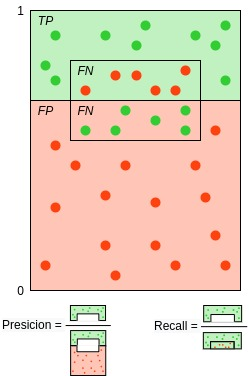

In [44]:
from IPython import display 
display.Image("../experiments/data/images/clf_metrics.jpg")

### Метрики для задач классификации:

_TP_ is true posistive;

_TN_ is true negative;

_FP_ is false positive;

_FN_ is false negative.

Для оценки моделей будем использовать следущие метрики:    
   
$$
    1. \ Precision = \dfrac{TP}{TP + FP};
$$

$$
    2. \ Recall = \dfrac{TP}{TP + FN};
$$

$$
    3. \ F_1 = 2 * \dfrac{Precision * Recall}{Precision + Recall}. 
$$

- ## Модель задачи классификации на Дереве решений

In [45]:
"""Prepare classification model using Decision Tree algorithm"""
def get_tree_classif_model(x_train, x_test, 
                           y_train, y_test, 
                           boundary=0.9, 
                           max_depth=10, 
                           splitter='best') -> Tuple[np.array, 
                                                     DecisionTreeClassifier, 
                                                     list, 
                                                     list]:
    binary_train = [1 if i >= boundary else 0 for i in y_train]
    binary_test = [1 if i >= boundary else 0 for i in y_test]
    clf = DecisionTreeClassifier(max_depth=max_depth, splitter=splitter)
    clf = clf.fit(x_train, binary_train)
    prob_estimate = clf.predict(x_test)
    return prob_estimate, clf, binary_train, binary_test

In [46]:
BOUNDARY = 0.9 
prob_clf_train = [1 if i > BOUNDARY else 0 for i in y_train['DeliveryProb']]
prob_clf_test = [1 if i > BOUNDARY else 0 for i in y_test['DeliveryProb']]

tree_prob_estimate, tree_clf, prob_clf_train, prob_clf_test = get_tree_classif_model(x_train, 
                                                                                     x_test, 
                                                                                     y_train['DeliveryProb'], 
                                                                                     y_test['DeliveryProb'],
                                                                                     boundary=BOUNDARY)

tree_prob_precision_score = '{:.3f}'.format(precision_score(prob_clf_test, tree_prob_estimate))
tree_prob_recall_score = '{:.3f}'.format(recall_score(prob_clf_test, tree_prob_estimate))
tree_prob_f1_score = '{:.3f}'.format(f1_score(prob_clf_test, tree_prob_estimate))
print(tree_prob_precision_score)
print(tree_prob_recall_score)
print(tree_prob_f1_score)

0.920
0.916
0.918


In [47]:
draw_data['TreeDeliveryProbTest'] = y_test['DeliveryProb']
draw_data['TreeDeliveryProbEst'] = tree_prob_estimate

In [48]:
# YLIM = [0.5, 1]
# net_size = draw_data['NetSize'].unique()
# net_size.sort()
# fig = plt.figure(figsize=(22, 40))
# fig.suptitle(r'Estimates of Delivery Packets Probability' + 
#              ' \n $Presicion$ = {}\n $Recall$ = {}\n $F_1$ = {}'.format(
#                 tree_prob_precision_score, 
#                 tree_prob_recall_score, 
#                 tree_prob_f1_score), fontsize=18)
# plt.subplots_adjust(top=0.95)
# for i in net_size:
#     draw_plot = draw_data.loc[draw_data['NetSize']==i]
#     ax = fig.add_subplot(5, 4,  int(i))
    
#     ax.title.set_text('Network size is ' + str(int(i)))    
#     plt.ylim(YLIM)

#     prob_color = ['limegreen' if i >BOUNDARY else 'orangered' for i in draw_plot['TreeDeliveryProbEst']]
#     ax.scatter(draw_plot['TreeDeliveryProbTest'].index, draw_plot['TreeDeliveryProbTest'], 
#                color=prob_color)
#     ax.add_patch(
#      patches.Rectangle(
#         (0, 0),
#         width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
#         height=BOUNDARY,
#         facecolor = 'coral',
#         fill=True,
#         alpha=0.3))
#     ax.add_patch(
#      patches.Rectangle(
#         (0, BOUNDARY),
#         width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
#         height=1 - BOUNDARY,
#         facecolor = 'aquamarine',
#         fill=True, alpha=0.3))

#     plt.xticks(color='w')   
#     ax.set_xlabel(r'$Test \ Samples$')
#     ax.set_ylabel(r'$Probability$')

In [33]:
YLIM = [0, 1]
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(16, 12))
# fig.suptitle(r'Estimates of Delivery Packets Probability' + 
#              ' \n $Presicion$ = {}\n $Recall$ = {}\n $F_1$ = {}'.format(
#                 tree_prob_precision_score, 
#                 tree_prob_recall_score, 
#                 tree_prob_f1_score), fontsize=18)
fig.suptitle(r' Decision Tree' + 
             ' \n Estimates of Delivery Packets Probability', 
             fontsize=25,
             fontweight='bold')
# plt.subplots_adjust(top=0.92)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=20)
plt.xticks([]) 
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
    if i in size:
        draw_plot = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(1, 4,  int(k))

        plt.title('Network size is ' + str(int(i)), fontsize=20, fontweight='bold')    
        plt.ylim(YLIM)

        prob_color = ['limegreen' if i >BOUNDARY else 'orangered' for i in draw_plot['TreeDeliveryProbEst']]
        ax.scatter(draw_plot['TreeDeliveryProbTest'].index, draw_plot['TreeDeliveryProbTest'], 
                   color=prob_color)
        ax.add_patch(
         patches.Rectangle(
            (0, 0),
            width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
            height=BOUNDARY,
            facecolor = 'coral',
            fill=True,
            alpha=0.3))
        ax.add_patch(
         patches.Rectangle(
            (0, BOUNDARY),
            width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
            height=1 - BOUNDARY,
            facecolor = 'aquamarine',
            fill=True, alpha=0.3))

        plt.xticks(color='w')   
        ax.set_xlabel(r'$Test \ Samples$')
        ax.set_ylabel(r'$Probability$')
        k += 1
        plt.xticks(color='w')
        plt.yticks(np.arange(0, 1.1, 0.1)) 
        ax.axis('off') 

plt.savefig('data/images/tree_clf_prob.pdf')

- ## Модель задачи классификации на многослойном персептроне с алгоритмом Adam

In [50]:
"""Prepare classification model using MLP algorithm"""
def get_mlp_classif_model(x_train, x_test, 
                          y_train, y_test,
                          boundary=0.9, 
                          solver='adam',
                          activation='relu',
                          hidden_layer_sizes=(16, 16, 16)) -> Tuple[np.array, 
                                                                  MLPClassifier,
                                                                  list, list]:
    
    binary_train = [1 if i > boundary else 0 for i in y_train]
    binary_test = [1 if i > boundary else 0 for i in y_test]

    clf = MLPClassifier(solver=solver, activation=activation, 
                        hidden_layer_sizes=hidden_layer_sizes, 
                        max_iter=2000, learning_rate='adaptive'
                        ).fit(x_train, binary_train)
    prob_estimate = clf.predict(x_test)

    return prob_estimate, clf, binary_train, binary_test

In [51]:
BOUNDARY = 0.9

mlpc_prob_estimate, mlpc_clf, prob_clf_train, prob_clf_test = get_mlp_classif_model(train_normalize,             test_normalize,
                                                                                    y_train['DeliveryProb'], 
                                                                                    y_test['DeliveryProb'],
                                                                                    boundary=0.9, 
                                                                                    hidden_layer_sizes=(54, 54))
mlpc_prob_precision_score = '{:.3f}'.format(precision_score(prob_clf_test, mlpc_prob_estimate))
mlpc_prob_recall_score = '{:.3f}'.format(recall_score(prob_clf_test, mlpc_prob_estimate))
mlpc_prob_f1_score = '{:.3f}'.format(f1_score(prob_clf_test, mlpc_prob_estimate))
print(mlpc_prob_precision_score)
print(mlpc_prob_recall_score)
print(mlpc_prob_f1_score)

0.973
0.981
0.977


In [52]:
draw_data['MLPCDeliveryProbEst'] = mlpc_prob_estimate

In [53]:
# YLIM = [0.5, 1]
# net_size = draw_data['NetSize'].unique()
# net_size.sort()
# fig = plt.figure(figsize=(22, 40))
# fig.suptitle(
#     'Estimates of Delivery Packets Probability \n $Presicion$ = {}\n $Recall$ = {}\n $F_1$ = {}'.format(
#         mlpc_prob_precision_score, 
#         mlpc_prob_recall_score, 
#         mlpc_prob_f1_score), 
#     fontsize=18)
# plt.subplots_adjust(top=0.95)
# for i in net_size:
#     draw_plot = draw_data.loc[draw_data['NetSize']==i]
#     ax = fig.add_subplot(5, 4,  int(i))
#     ax.axhspan(0, .9, color='coral', zorder=0, alpha=0.3)
#     ax.axhspan(.9, 1, color='aquamarine', zorder=0, alpha=0.3)
#     ax.title.set_text('Network size is ' + str(int(i)))    
#     plt.ylim(YLIM)

#     prob_color = ['limegreen' if i >BOUNDARY else 'orangered' for i in draw_plot['MLPCDeliveryProbEst']]
#     ax.scatter(draw_plot['TreeDeliveryProbTest'].index, draw_plot['TreeDeliveryProbTest'], 
#                color=prob_color)
#     plt.xticks(color='w')
#     plt.yticks(np.arange(0, 1.1, 0.1))   
#     ax.set_xlabel(r'$Test \ Samples$')
#     ax.set_ylabel(r'$Probability$')

In [34]:
YLIM = [0, 1]
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(16, 12))

fig.suptitle(r' Neural Network' + 
             ' \n Estimates of Delivery Packets Probability', 
             fontsize=25,
             fontweight='bold')

plt.yticks(np.arange(0, 1.1, 0.1), fontsize=20)
plt.xticks([])
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
    if i in size:
        draw_plot = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(1, 4,  int(k))

        plt.title('Network size is ' + str(int(i)), fontsize=20, fontweight='bold')    
        plt.ylim(YLIM)

        prob_color = ['limegreen' if i >BOUNDARY else 'orangered' for i in draw_plot['MLPCDeliveryProbEst']]
        ax.scatter(draw_plot['TreeDeliveryProbTest'].index, draw_plot['TreeDeliveryProbTest'], 
                   color=prob_color)
        ax.add_patch(
         patches.Rectangle(
            (0, 0),
            width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
            height=BOUNDARY,
            facecolor = 'coral',
            fill=True,
            alpha=0.3))
        ax.add_patch(
         patches.Rectangle(
            (0, BOUNDARY),
            width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
            height=1 - BOUNDARY,
            facecolor = 'aquamarine',
            fill=True, alpha=0.3))

        plt.xticks(color='w')   
        ax.set_xlabel(r'$Test \ Samples$')
        ax.set_ylabel(r'$Probability$')
        k += 1
        plt.xticks(color='w')
        plt.yticks(np.arange(0, 1.1, 0.1))   
        ax.axis('off') 
plt.savefig('data/images/ann_clf_prob.pdf')

- ## Модель задачи классификации на градиентном бустинге с алгоритмом CatBoost

In [55]:
"""Prepare classification model using Cat Boost algorithm"""
def get_catboost_classif_model(x_train, x_test, 
                               y_train, y_test)-> Tuple[np.array, 
                                                        CatBoostClassifier, 
                                                        list, 
                                                        list]: 
    catboost_clf = CatBoostClassifier(iterations=1000,
                                        learning_rate=0.1);
    binary_train = [1 if i > BOUNDARY else 0 for i in y_train]
    binary_test = [1 if i > BOUNDARY else 0 for i in y_test]
    catboost_clf.fit(x_train, binary_train);
    catboost_prob_estimate = catboost_clf.predict(x_test);
    
    return catboost_prob_estimate, catboost_clf, binary_train, binary_test

In [35]:
catboost_prob_estimate, catboost_clf, prob_clf_train, prob_clf_test = get_catboost_classif_model(
    x_train, 
    x_test, 
    y_train['DeliveryProb'], 
    y_test['DeliveryProb'])

catboost_prob_precision_score = '{:.3f}'.format(precision_score(prob_clf_test, catboost_prob_estimate))
catboost_prob_recall_score = '{:.3f}'.format(recall_score(prob_clf_test, catboost_prob_estimate))
catboost_prob_f1_score = '{:.3f}'.format(f1_score(prob_clf_test, catboost_prob_estimate))
print(catboost_prob_precision_score)
print(catboost_prob_recall_score)
print(catboost_prob_f1_score)
    

In [57]:
draw_data['CatBoostProbEst'] = catboost_prob_estimate

In [36]:
YLIM = [0, 1]
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(16, 12))

fig.suptitle(r' Gradient Boosting' + 
             ' \n Estimates of Delivery Packets Probability', 
             fontsize=25,
             fontweight='bold')

plt.yticks(np.arange(0, 1.1, 0.1), fontsize=20)
plt.xticks([]) 
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
    if i in size:
        draw_plot = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(1, 4,  int(k))

        plt.title('Network size is ' + str(int(i)), fontsize=20, fontweight='bold')    
        plt.ylim(YLIM)

        prob_color = ['limegreen' if i >BOUNDARY else 'orangered' for i in draw_plot['CatBoostProbEst']]
        ax.scatter(draw_plot['TreeDeliveryProbTest'].index, draw_plot['TreeDeliveryProbTest'], 
                   color=prob_color)
        ax.add_patch(
         patches.Rectangle(
            (0, 0),
            width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
            height=BOUNDARY,
            facecolor = 'coral',
            fill=True,
            alpha=0.3))
        ax.add_patch(
         patches.Rectangle(
            (0, BOUNDARY),
            width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
            height=1 - BOUNDARY,
            facecolor = 'aquamarine',
            fill=True, alpha=0.3))

        plt.xticks(color='w')   
        ax.set_xlabel(r'$Test \ Samples$')
        ax.set_ylabel(r'$Probability$')
        k += 1
        plt.xticks(color='w')
        plt.yticks(np.arange(0, 1.1, 0.1))
        ax.axis('off')    
plt.savefig('data/images/catboost_clf_prob.pdf')

- ## Модель задачи классификации c помощью логистической регрессии

In [60]:
"""Prepare classification model using Logistic Regression algorithm"""
def get_logress_classif_model(x_train, x_test, 
                              y_train, y_test,
                              boundary=0.9)-> Tuple[np.array, LogisticRegression,
                                                    list, list]: 
    logres_model = LogisticRegression(max_iter=1000)
    binary_train = [1 if i > boundary else 0 for i in y_train]
    binary_test = [1 if i > boundary else 0 for i in y_test]
    logres_model.fit(x_train, binary_train)
    logres_prob_estimate = logres_model.predict(x_test)
    
    return logres_prob_estimate, logres_model, binary_train, binary_test

In [61]:
logres_prob_estimate, logres_model, prob_clf_train, prob_clf_test = get_logress_classif_model(x_train, 
                                                                                x_test, 
                                                                                y_train['DeliveryProb'], 
                                                                                y_test['DeliveryProb'],
                                                                                boundary=BOUNDARY)

logres_prob_precision_score = '{:.3f}'.format(precision_score(prob_clf_test, logres_prob_estimate))
logres_prob_recall_score = '{:.3f}'.format(recall_score(prob_clf_test, logres_prob_estimate))
logres_prob_f1_score = '{:.3f}'.format(f1_score(prob_clf_test, logres_prob_estimate))
print(logres_prob_precision_score)
print(logres_prob_recall_score)
print(logres_prob_f1_score)

0.897
0.869
0.883


In [62]:
draw_data['LogResProbEst'] = logres_prob_estimate

In [37]:
YLIM = [0, 1]
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(16, 12))
fig.suptitle(r'Logistic Regression' + 
             ' \n Estimates of Delivery Packets Probability', 
             fontsize=25,
             fontweight='bold')
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=20)
plt.xticks([]) 
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
    if i in size:
        draw_plot = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(1, 4,  int(k))

        plt.title('Network size is ' + str(int(i)), fontsize=20, fontweight='bold')    
        plt.ylim(YLIM)

        prob_color = ['limegreen' if i >BOUNDARY else 'orangered' for i in draw_plot['LogResProbEst']]
        ax.scatter(draw_plot['TreeDeliveryProbTest'].index, draw_plot['TreeDeliveryProbTest'], 
                   color=prob_color)
        ax.add_patch(
         patches.Rectangle(
            (0, 0),
            width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
            height=BOUNDARY,
            facecolor = 'coral',
            fill=True,
            alpha=0.3))
        ax.add_patch(
         patches.Rectangle(
            (0, BOUNDARY),
            width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
            height=1 - BOUNDARY,
            facecolor = 'aquamarine',
            fill=True, alpha=0.3))

        plt.xticks(color='w')   
        ax.set_xlabel(r'$Test \ Samples$')
        ax.set_ylabel(r'$Probability$')
        k += 1
        plt.xticks(color='w')
        plt.yticks(np.arange(0, 1.1, 0.1))
        ax.axis('off')    
plt.savefig('data/images/logres_clf_prob.pdf')

Все модели классификации

In [38]:
YLIM = [0, 1]
column_name = ['LogResProbEst', 'TreeDeliveryProbEst','CatBoostProbEst', 'MLPCDeliveryProbEst']
title_name = ['Logistic Regression', 'Decision Tree', 'Gradient Boosting', 'Neural Network']

fig = plt.figure(figsize=(13, 6))

plt.yticks(np.arange(0, 1.1, 0.2), fontsize=16) 
plt.xlabel(r'$Test \ Samples$', fontsize=18)
plt.ylabel(r'$Probability$', fontsize=18) 
plt.tick_params(
        axis='both',          
        which='both',     
        bottom=False,      
        top=False,     
        labelbottom=False,
        left=False)

for i in range(len(column_name)):

    ax = fig.add_subplot(1, 4,  int(i+1))

    plt.rcParams['axes.titley'] = 1.0 
    plt.rcParams['axes.titlepad'] = 40 
    plt.title(str(title_name[i]), fontsize=20, fontdict={'verticalalignment': 'top'})
      
    plt.ylim(YLIM)

    prob_color = ['limegreen' if i >BOUNDARY else 'orangered' for i in draw_data[column_name[i]]]
    ax.scatter(draw_data['TreeDeliveryProbTest'].index, draw_data['TreeDeliveryProbTest'], 
               color=prob_color)
    ax.add_patch(
        patches.Rectangle(
        (0, 0),
        width=draw_data.loc[:,'TreeDeliveryProbTest'].index.max(),
        height=BOUNDARY,
        facecolor = 'coral',
        fill=True,
        alpha=0.3))
    ax.add_patch(
        patches.Rectangle(
        (0, BOUNDARY),
        width=draw_data.loc[:,'TreeDeliveryProbTest'].index.max(),
        height=1 - BOUNDARY,
        facecolor = 'aquamarine',
        fill=True, alpha=0.3))
    ax.axis('off')

    
plt.savefig('data/images/total_clf_prob.pdf')

Мы получили прогнозные модели времени межконцевой задержки и вероятности доставки пакетов в тандемности сети. Проверим адекватность моделей для тестовых данных:
- для различных коэффициентов загрузок $\rho$;
- для различных длин тандема.

### Оценки времени задержки и вероятности доставки пакетов от коэффициента загрузки

In [65]:
COLUMNS = (
    'ArrM1',
    'ArrM2',
    'ArrM3',
    'ArrAvg', 
    'ArrStd', 
    'ArrCv',
    'ArrSkewness',
    'SrvM1',
    'SrvM2',
    'SrvM3',
    'SrvAvg', 
    'SrvStd', 
    'SrvCv',
    'SrvSkewness', 
    'Rho', 
    'NetSize', 
    'Capacity', 
    'NumPackets',
    'DelayAvg', 
    'DelayStd', 
    'DeliveryProb',
)

arr_m1 = [np.random.uniform(0, 10)]
arr_cv = [np.random.uniform(0.5, 3)]

rho =  np.arange(0.1, 1, 0.05)

srv_cv = [np.random.uniform(0.5, 3)]

net_size = np.arange(1, 20+1)
capacity = [10]


In [66]:
sim_data_rho_netsize = pd.DataFrame(columns=COLUMNS)

In [67]:
REPEAT = True
start_time = time.time()
if REPEAT:
    for _arr_m1, _arr_cv, _rho, \
        _srv_cv, _net_size, _capacity in tqdm(product(arr_m1, arr_cv, \
            rho, srv_cv, net_size, capacity)):

            _arr_skewness = np.random.uniform(_arr_cv - 1/_arr_cv, 100)
            _srv_m1 = _rho * _arr_m1
            _srv_skewness = np.random.uniform(_srv_cv - 1/_srv_cv, 100)

            sim_data_rho_netsize = simulate(
                sim_data_rho_netsize,
                arr_m1=_arr_m1,
                arr_m2=get_noncentral_m2(_arr_m1, _arr_cv),
                arr_m3=get_noncentral_m3(_arr_m1, _arr_cv, _arr_skewness),
                srv_m1=_srv_m1,
                srv_m2=get_noncentral_m2(_srv_m1, _srv_cv),
                srv_m3=get_noncentral_m3(_srv_m1, _srv_cv, _srv_skewness),
                net_size=_net_size,
                capacity=_capacity,
                num_packets=NUM_PACKETS,
                force=FORCE_SIMULATION
            )
    print(f'Evaluation time = {time.time() - start_time}')
    print(sim_data_rho_netsize.info())
    print(sim_data_rho_netsize)

    sim_data_rho_netsize.to_csv('./data/Tandem_network_data_with_different_rho_and_netsize.csv')

0it [00:00, ?it/s]

NameError: name 'simulate' is not defined

In [78]:
sim_data_rho_netsize = pd.read_csv('./data/Tandem_network_data_with_different_rho_and_netsize.csv')

In [95]:
COLUMNS = [
    'ArrM1',
    'ArrStd',
    'ArrSkewness',
    'SrvM1',
    'SrvStd',
    'SrvSkewness',
    'NetSize', 
    'Capacity',
    ]
x_test_rho_netsize = sim_data_rho_netsize.loc[:, COLUMNS]
x_test_rho_netsize
y_test_delay = sim_data_rho_netsize['DelayAvg']
y_test_prob = sim_data_rho_netsize['DeliveryProb']

In [414]:
def get_regression_metrics(test, estimate) -> Tuple[float, float, float]:
    r = corr(test, estimate)
    _std = std(test, estimate)
    mse = mean_squared_error(test, estimate)
    # mse = mean_squared_error(test, estimate)
    r2 = r2_score(test, estimate)
    mape = mean_absolute_percentage_error(test, estimate)
    return r, _std, mse, r2, mape

In [97]:
def get_classification_metrics(test, estimate) -> Tuple[float, float, float]:
    precision = precision_score(test, estimate)
    recall = recall_score(test, estimate)
    f1 = f1_score(test, estimate)
    return precision, recall, f1

### Прогнозирование времени задержек

In [422]:
%time
ls_rho_netsize_estimate = ls.predict(x_test_rho_netsize)
R, STD, MSE, R2, MAPE = get_regression_metrics(y_test_delay, ls_rho_netsize_estimate)
print(f'R = {R:.3f}')
print(f'STD = {STD:.3f}')
print(f'MSE = {MSE:.3f}')
print(f'R2 = {R2:.3f}')
print(f'MAPE  = {MAPE:.3f}')
sim_data_rho_netsize['ls_estimate'] = ls_rho_netsize_estimate

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs
R = 0.767
STD = 72.924
MSE = 5303.174
R2 = -0.638
MAPE  = 7.218


In [421]:
%time
tree_rho_netsize_estimate = tree_reg.predict(x_test_rho_netsize)
R, STD, MSE, R2, MAPE  = get_regression_metrics(y_test_delay, tree_rho_netsize_estimate)
print(f'R = {R:.3f}')
print(f'STD = {STD:.3f}')
print(f'MSE = {MSE:.3f}')
print(f'R2 = {R2:.3f}')
print(f'MAPE = {MAPE:.3f}')
sim_data_rho_netsize['tree_estimate'] = tree_rho_netsize_estimate

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
R = 0.972
STD = 13.519
MSE = 182.265
R2 = 0.944
MAPE = 0.160


In [420]:
%time
gtb_rho_netsize_estimate = gtb.predict(x_test_rho_netsize)
R, STD, MSE, R2, MAPE = get_regression_metrics(y_test_delay, gtb_rho_netsize_estimate)
print(f'R = {R:.3f}')
print(f'STD = {STD:.3f}')
print(f'MSE = {MSE:.3f}')
print(f'R2 = {R2:.3f}')
print(f'MAPE = {MAPE:.3f}')
sim_data_rho_netsize['gtb_estimate'] = gtb_rho_netsize_estimate

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
R = 0.971
STD = 13.696
MSE = 187.073
R2 = 0.942
MAPE = 0.158


In [419]:
%time
test_normalize = normalize(x_test_rho_netsize, 
                           simulation_data.loc[:,COLUMNS].describe())
ann_rho_netsize_estimate = ann.predict(test_normalize).flatten()
R, STD, MSE, R2, MAPE = get_regression_metrics(y_test_delay, ann_rho_netsize_estimate)
print(f'R = {R:.3f}')
print(f'STD = {STD:.3f}')
print(f'MSE = {MSE:.3f}')
print(f'R2 = {R2:.3f}')
print(f'MAPE = {MAPE:.3f}')
sim_data_rho_netsize['ann_estimate'] = ann_rho_netsize_estimate

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.25 µs
R = 0.990
STD = 11.661
MSE = 135.595
R2 = 0.958
MAPE = 0.343


In [ ]:
size = [i for i in range(21)]
k = 1
for i in net_size:
    if i in size:
        draw = sim_data_rho_netsize.loc[sim_data_rho_netsize['NetSize']==i]
        plt.plot(draw['Rho'], draw['DelayStd'], '-o', color="black",
                linewidth=2, markersize=8, 
                label='Monte Carlo method')

In [39]:
net_size = sim_data_rho_netsize['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(15, 9))
size = [1, 5, 10, 20 ]
k = 1
for i in net_size:
    if i in size:
        draw = sim_data_rho_netsize.loc[sim_data_rho_netsize['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        
        ax.set_title('Network size is ' + str(int(i)), fontsize=24)    
        plt.plot(draw['Rho'], draw['DelayAvg'], '-D', 
                color='chocolate', label='Monte Carlo method',
                linewidth=6, markersize=10)
        plt.plot(draw['Rho'], draw['ls_estimate'], '-o', color="mediumseagreen",
                linewidth=2, markersize=8, 
                label='Least Squares estimate')
        plt.plot(draw['Rho'], draw['tree_estimate'], '-o', color="gold", 
                linewidth=2, markersize=8, 
                label='Decision Tree estimate')
        plt.plot(draw['Rho'], draw['gtb_estimate'], '-o', color="mediumblue", 
                linewidth=2, markersize=8, 
                label='Gradient Tree Boosting estimate')
        plt.plot(draw['Rho'], draw['ann_estimate'], '-o', color="fuchsia",
                linewidth=2, markersize=8, 
                label='Artificial Neural Network estimate')
        plt.yticks(fontsize='20')
        plt.xticks(np.arange(0, 1, 0.1), fontsize='20')
        fig.tight_layout() 
        
        plt.grid()
        plt.ylabel(r'$Delay$',fontsize='22')
        plt.xlabel(r'$m_s$ \ $m_a$',fontsize='22')
        k += 1
ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0, -0.82), prop={'size': 22})
plt.savefig('data/images/rho_total_delay_est.pdf')

### Прогнозирование вероятности доставки

In [104]:
binary_prob_test = [1 if i > BOUNDARY else 0 for i in y_test_prob]

In [105]:
%time
logres_prob_rho_netsize_estimate = logres_model.predict(x_test_rho_netsize)
Precision, Recall, F1 = get_classification_metrics(binary_prob_test, 
                                                   logres_prob_rho_netsize_estimate)
print(f'Precision = {Precision:.3f}')
print(f'Recall = {Recall:.3f}')
print(f'F1 = {F1:.3f}')
sim_data_rho_netsize['logres_prob_estimate'] = logres_prob_rho_netsize_estimate

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.77 µs
Precision = 0.912
Recall = 0.825
F1 = 0.866


In [106]:
%time
tree_prob_rho_netsize_estimate = tree_clf.predict(x_test_rho_netsize)
Precision, Recall, F1 = get_classification_metrics(binary_prob_test, 
                                                   tree_prob_rho_netsize_estimate)
print(f'Precision = {Precision:.3f}')
print(f'Recall = {Recall:.3f}')
print(f'F1 = {F1:.3f}')
sim_data_rho_netsize['tree_prob_estimate'] = tree_prob_rho_netsize_estimate

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
Precision = 0.957
Recall = 0.892
F1 = 0.924


In [107]:
%time
catboost_prob_rho_netsize_estimate = catboost_clf.predict(x_test_rho_netsize)
Precision, Recall, F1 = get_classification_metrics(binary_prob_test, 
                                                   catboost_prob_rho_netsize_estimate)
print(f'Precision = {Precision:.3f}')
print(f'Recall = {Recall:.3f}')
print(f'F1 = {F1:.3f}')
sim_data_rho_netsize['catboost_prob_estimate'] = catboost_prob_rho_netsize_estimate

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 25.3 µs
Precision = 0.965
Recall = 0.976
F1 = 0.970


In [108]:
%time
test_prob_rho_normalize = normalize(x_test_rho_netsize, 
                                    simulation_data.loc[:,COLUMNS].describe())
ann_prob_rho_netsize_estimate = mlpc_clf.predict(test_prob_rho_normalize)
Precision, Recall, F1 = get_classification_metrics(binary_prob_test, 
                                                   ann_prob_rho_netsize_estimate)
print(f'Precision = {Precision:.3f}')
print(f'Recall = {Recall:.3f}')
print(f'F1 = {F1:.3f}')
sim_data_rho_netsize['ann_prob_estimate'] = ann_prob_rho_netsize_estimate

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs
Precision = 0.973
Recall = 0.992
F1 = 0.982


In [109]:
label = ['Logistic Regression model',
         'Decision tree model',
         'Gradient Boosting model',
         'Neural network model']
label[0].replace(' ', '_')

'Logistic_Regression_model'

In [40]:
label = ['Logistic Regression model',
         'Decision tree model',
         'Gradient Boosting model',
         'Neural network model']
model = ['logres_prob_estimate',
         'tree_prob_estimate',
         'ann_prob_estimate',
         'catboost_prob_estimate']
net_size = [10]
for i in net_size:
    if i in size:
        net_size = sim_data_rho_netsize['NetSize'].unique()
        net_size.sort()
        fig = plt.figure(figsize=(14, 9))
        fig.suptitle('Network size is ' + str(int(i)), fontsize=24)
        plt.subplots_adjust(top=0.99)
        size = [1, 5, 10, 20]
        k = 1
        for j in range(len(label)):    
            draw = sim_data_rho_netsize.loc[sim_data_rho_netsize['NetSize']==i]
            prob_color = ['limegreen' if i > BOUNDARY 
                        else 'orangered' 
                        for i in draw[model[j]]]
            ax = fig.add_subplot(2, 2, int(k))
            plt.yticks(np.arange(0.7, 1.1, 0.1), fontsize=18)  
            plt.title(label[j], fontsize=20)
            plt.plot(draw['Rho'], draw['DeliveryProb'], '-', color="dimgray",
                    linewidth=2, markersize=4, marker='x', 
                    label='Monte Carlo method')    
            ax.scatter(draw['Rho'], draw['DeliveryProb'], 
                    label='Prediction',
                    color=prob_color, s=150)
            ax.hlines(BOUNDARY, 0, 1, color='r')
            ax.add_patch(
            patches.Rectangle(
                (0, 0.7),
                width=1,
                height=BOUNDARY - 0.7,
                facecolor = 'coral',
                fill=True,
                alpha=0.3))
            ax.add_patch(
            patches.Rectangle(
                (0, BOUNDARY),
                width=1,
                height=1 - BOUNDARY,
                facecolor = 'aquamarine',
                fill=True, alpha=0.3))
            plt.xticks(np.arange(0, 1, 0.1), fontsize=18)  
   
            plt.grid()
            plt.xlabel(r'$m_s$ \ $m_a$', fontsize=20)
            plt.ylabel(r'$Probability$', fontsize=20)
            fig.tight_layout() 
            k += 1
    ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0, -0.65), prop={'size': 20})
    plt.savefig('data/images/rho_total_prob_est.pdf', bbox_inches = 'tight')